# Машинное обучение, ФКН ВШЭ

# Практическое задание 6. Бустинговое

## Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 24.12.2023 23:59 MSK

Жёсткий дедлайн: 24.12.2023 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [14]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve



sns.set(style='darkgrid')
filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустингового (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [17]:
from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [18]:
import time

boosting = Boosting()

start_time = time.time()
boosting.fit(x_train, y_train, x_valid, y_valid)
end_time = time.time()

print(f"Время выполнения: {end_time - start_time} секунд")

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')


Время выполнения: 1.261625051498413 секунд
Train ROC-AUC 0.9896
Valid ROC-AUC 0.9044
Test ROC-AUC 0.9135


## Задание 2. Обучение градиентного бустингового (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

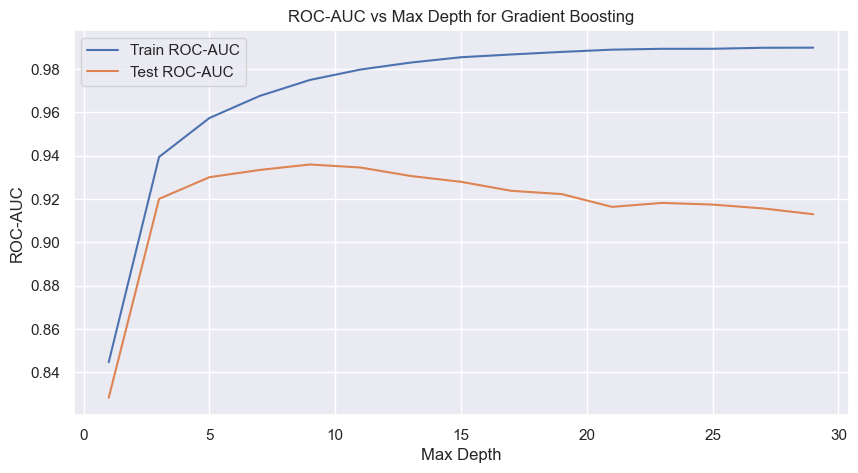

In [19]:
train_scores = []
test_scores = []

for depth in range(1, 31, 2):
    boosting = Boosting(base_model_params={'max_depth': depth, 'random_state':42})
    boosting.fit(x_train, y_train, x_train, y_train)  
    train_scores.append(boosting.score(x_train, y_train))
    test_scores.append(boosting.score(x_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 31, 2), train_scores, label='Train ROC-AUC')
plt.plot(range(1, 31, 2), test_scores, label='Test ROC-AUC')
plt.xlabel('Max Depth')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC vs Max Depth for Gradient Boosting')
plt.legend()
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

__Ответ:__ Наилучшим качеством обладает модель с глубинной базовых моделей 7 - то есть с не слишком глубокими деревьями. Так как видно, что далее качество на тесте растет, а на трейне падает - можно сделать вывод о том, что при дальнейшем усложении базовых моделей падает обобщающая способность моделей, они переобучаются на остатки и плохо предсказывают новые данные.

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (3 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей. Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/).

In [20]:
!pip install optuna

In [21]:
# YOUR CODE:
import optuna
from sklearn.metrics import roc_auc_score

def objective(trial):
    # Гиперпараметры для бустинга
    n_estimators = trial.suggest_int('n_estimators', 1, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 1, 50)

    # Гиперпараметры для базовой модели (решающее дерево)
    max_depth = trial.suggest_int('max_depth', 1, 30)

    # Создание модели
    boosting = Boosting(base_model_params={'max_depth': max_depth, 'random_state': 42}, 
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        subsample=subsample,
                        early_stopping_rounds = early_stopping_rounds)

    # Обучение модели
    boosting.fit(x_train, y_train, x_valid, y_valid)

    # Оценка модели
    valid_pred = boosting.predict_proba(x_valid)
    return roc_auc_score(y_valid, valid_pred[:, 1])


In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:', study.best_trial.params)

[I 2023-12-24 23:10:34,195] A new study created in memory with name: no-name-3933b668-3a4b-4749-a4a8-bd97efb0ab4f
[I 2023-12-24 23:10:37,259] Trial 0 finished with value: 0.9395075002015433 and parameters: {'n_estimators': 38, 'learning_rate': 0.267528422096403, 'subsample': 0.6390317999411378, 'early_stopping_rounds': 45, 'max_depth': 9}. Best is trial 0 with value: 0.9395075002015433.
[I 2023-12-24 23:10:37,391] Trial 1 finished with value: 0.9101157137463654 and parameters: {'n_estimators': 3, 'learning_rate': 0.45111702705149476, 'subsample': 0.8916680425955651, 'early_stopping_rounds': 18, 'max_depth': 3}. Best is trial 0 with value: 0.9395075002015433.
[I 2023-12-24 23:10:43,894] Trial 2 finished with value: 0.9322387740425101 and parameters: {'n_estimators': 34, 'learning_rate': 0.06186235602059321, 'subsample': 0.6797343962063904, 'early_stopping_rounds': 2, 'max_depth': 15}. Best is trial 0 with value: 0.9395075002015433.
[I 2023-12-24 23:10:50,167] Trial 3 finished with value

Best trial: {'n_estimators': 50, 'learning_rate': 0.3170824019259023, 'subsample': 0.8558459450124554, 'early_stopping_rounds': 32, 'max_depth': 9}


In [23]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

## Задание 4. Интерпретация бустингового (2 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

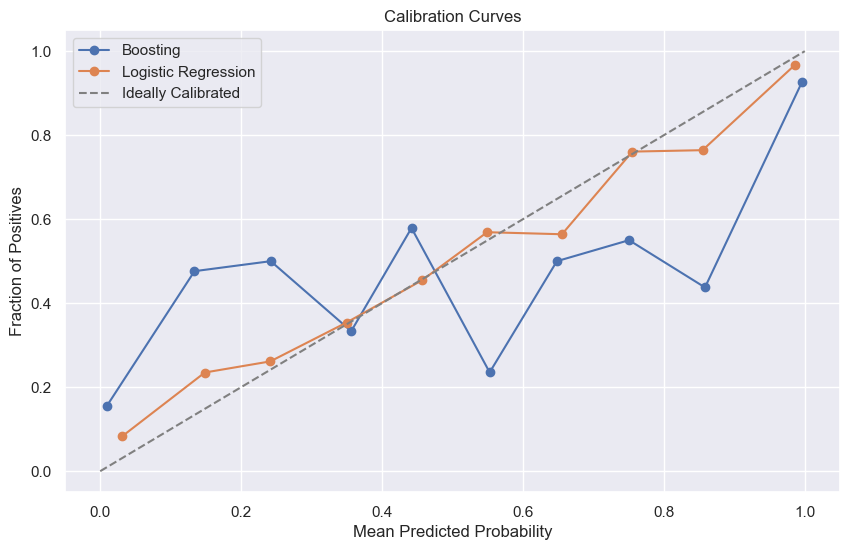

In [24]:
best_boosting_model = Boosting(base_model_params={'max_depth': study.best_trial.params['max_depth'], 'random_state': 42}, 
                        n_estimators=study.best_trial.params['n_estimators'],
                        learning_rate=study.best_trial.params['learning_rate'],
                        subsample=study.best_trial.params['subsample'],
                        early_stopping_rounds=study.best_trial.params['early_stopping_rounds'])

best_boosting_model.fit(x_train, y_train, x_valid, y_valid)
best_score = roc_auc_score(y_test, best_boosting_model.predict_proba(x_test)[:, 1])
log_reg = LogisticRegression().fit(x_train, y_train)

prob_boosting = best_boosting_model.predict_proba(x_test)[:, 1]
prob_log_reg = log_reg.predict_proba(x_test)[:, 1]

prob_true_boosting, prob_pred_boosting = calibration_curve(y_test, prob_boosting, n_bins=10)
prob_true_log_reg, prob_pred_log_reg = calibration_curve(y_test, prob_log_reg, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred_boosting, prob_true_boosting, marker='o', label='Boosting')
plt.plot(prob_pred_log_reg, prob_true_log_reg, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Ideally Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves')
plt.legend()
plt.show()


__Интуиция:__ Мы можем видеть, что градиентный бустинг хуже предсказывает вероятности - он выдает большие вероятнсти чем нужно как для положительного, так и для отрицательного класса, т.е. он слищком уверен в своих прогнозах. Так как функция потерь у бустинга аналогична логистической регрессии и также используется сигмоида,  то единственным разумным объяснением для такого факта является то, что модели деревьев решений, лежащих в основе написанного бустинг, склонны к переробучению и к излишней уверенности в классах. 

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.
На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики.
Нарисуйте столбчатую диаграмму важности признаков.  Проанализируйте полученные результаты.

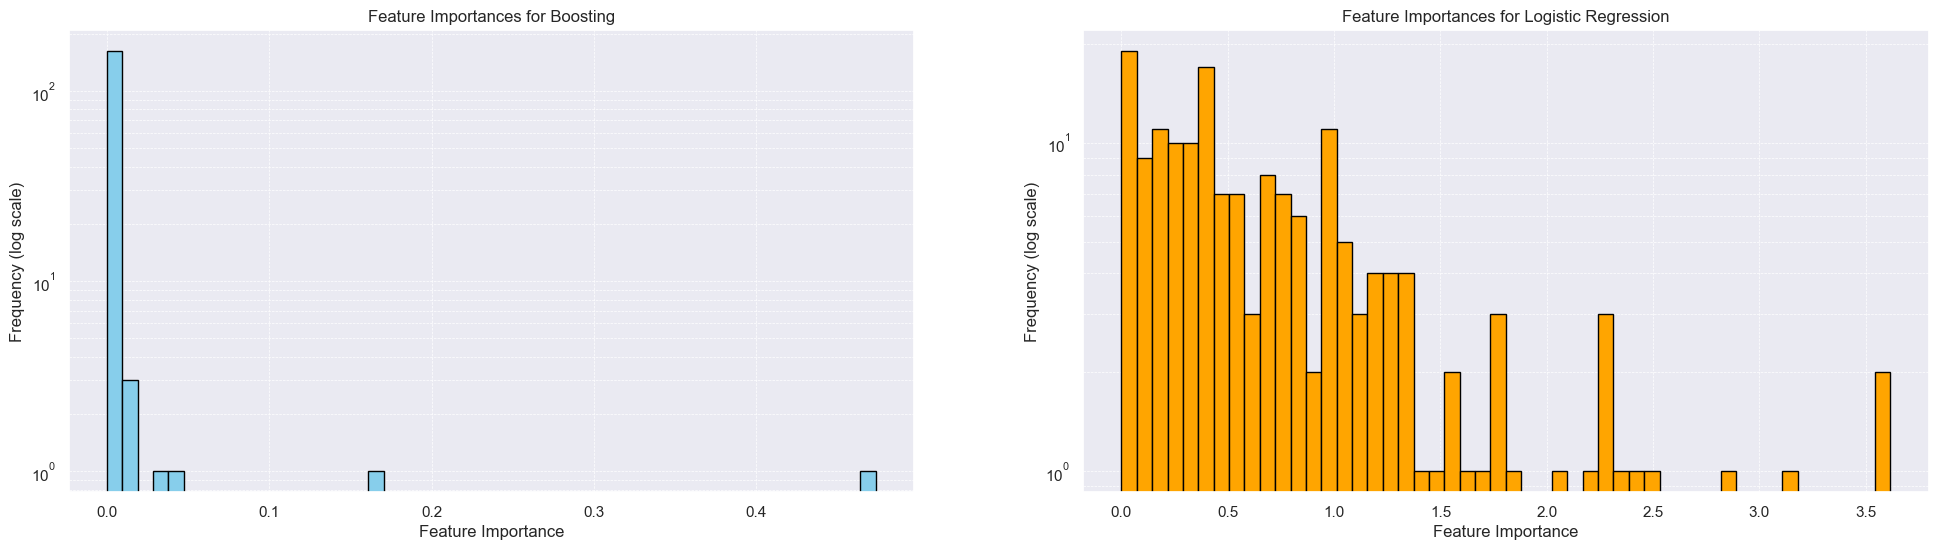

In [25]:
feature_importances = best_boosting_model.feature_importances_

logistic_model = LogisticRegression().fit(np.random.rand(100, 10), np.random.randint(0, 2, 100))
logistic_importances = np.abs(log_reg.coef_[0])

# Создание графиков
plt.figure(figsize=(24, 6))

# График для бустинга
plt.subplot(1, 2, 1)
plt.hist(feature_importances, bins=50, log=True, color='skyblue', edgecolor='black')
plt.title('Feature Importances for Boosting')
plt.xlabel('Feature Importance')
plt.ylabel('Frequency (log scale)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# График для логистической регрессии
plt.subplot(1, 2, 2)
plt.hist(logistic_importances, bins=50, log=True, color='orange', edgecolor='black')
plt.title('Feature Importances for Logistic Regression')
plt.xlabel('Feature Importance')
plt.ylabel('Frequency (log scale)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.show()

___
Можем заметить, что в датасете очень много признаков, не предсказывающих целевую переменную, у которых околонулевая важность. И есть несколько важных, поэтому значительный объем признаков можем убрать. Этот вывод можно сделать исходя из модели бустинга. Если же сравнивать важность фичей, которую показала модель бустинга и логичтисеской регрессии, то можно заметить, что, с одной стороны они похожи, так как примерно в одинаковых участках наблюдаются выбросы и скопления, однако все же для лоргистической регрессии важность признаков более равномерно распределена, в то время как бустинг очень категорично делит признаки.
___

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [29]:
quantile_20 = np.quantile(feature_importances, 0.2)
important_feature_indices = np.where(feature_importances >= quantile_20)[0]

shortened_parametres_boosting = Boosting(base_model_params={'max_depth': study.best_trial.params['max_depth'], 'random_state': 42}, 
                        n_estimators=study.best_trial.params['n_estimators'],
                        learning_rate=study.best_trial.params['learning_rate'],
                        subsample=study.best_trial.params['subsample'],
                        early_stopping_rounds=study.best_trial.params['early_stopping_rounds'])

shortened_parametres_boosting.fit(
    x_train[:, important_feature_indices], 
    y_train, 
    x_valid[:, important_feature_indices], 
    y_valid
)

new_score = roc_auc_score(
    y_test, 
    shortened_parametres_boosting.predict_proba(x_test[:, important_feature_indices])[:, 1]
)

print(best_score, new_score)

0.9382103938922066 0.9382922677969464


___
Да, стало лучше, хоть я и взял очень маленткий квантиль
___

## Задание 5 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

__биз белндинга кароче__


можно плюс балл за честность

## Задание 6 (бонус). Катбустовое (1 балл)

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [32]:
!pip install catboost
from catboost import CatBoostClassifier

In [33]:
model = CatBoostClassifier()

model.fit(x_train, y_train)

predictions_proba = model.predict_proba(x_test)[:, 1]

roc_auc = roc_auc_score(y_test, predictions_proba)
print(f'ROC AUC для модели CatBoost: {roc_auc}')

Learning rate set to 0.036078
0:	learn: 0.6491463	total: 180ms	remaining: 2m 59s
1:	learn: 0.6106105	total: 185ms	remaining: 1m 32s
2:	learn: 0.5804629	total: 190ms	remaining: 1m 3s
3:	learn: 0.5522558	total: 197ms	remaining: 49s
4:	learn: 0.5262196	total: 203ms	remaining: 40.4s
5:	learn: 0.5008075	total: 208ms	remaining: 34.4s
6:	learn: 0.4812963	total: 215ms	remaining: 30.5s
7:	learn: 0.4620364	total: 220ms	remaining: 27.3s
8:	learn: 0.4461814	total: 225ms	remaining: 24.8s
9:	learn: 0.4303347	total: 231ms	remaining: 22.9s
10:	learn: 0.4142074	total: 236ms	remaining: 21.2s
11:	learn: 0.4011998	total: 242ms	remaining: 19.9s
12:	learn: 0.3907487	total: 248ms	remaining: 18.8s
13:	learn: 0.3808040	total: 252ms	remaining: 17.8s
14:	learn: 0.3710194	total: 258ms	remaining: 16.9s
15:	learn: 0.3641415	total: 264ms	remaining: 16.2s
16:	learn: 0.3554514	total: 269ms	remaining: 15.5s
17:	learn: 0.3492319	total: 274ms	remaining: 15s
18:	learn: 0.3419545	total: 280ms	remaining: 14.5s
19:	learn: 0.

In [34]:
print(f'ROC AUC для моей модели GBM: {new_score}')

ROC AUC для моей модели GBM: 0.9382922677969464


___
CatBoost работает слегка лучше - буквально на 0.003 - что на самом деле на грани погрешности. Работают две модели почти одинаково
___

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2024 года?